In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os; import json
import matplotlib.pyplot as plt;import os;import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17; # python -m ipykernel install --user --name=EnvPBGEM_Linux --display-name "Python_Linux"
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
## Global setting: change with PC or HPC
# Path_NiallDMA = "InputData/" # for HPC

# Path_NiallDMA = "D:/OneDrive - Imperial College London/SimDataSave/InputData/" # for Windows
Path_NiallDMA = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
# BasicPath=os.getcwd() # for HPC
# path for windows's pybamm in office PC 
# BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2_R9_Dim/Test'  
# for linux pybamm in office pc:
BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

# Set Experiment : Exp-2
index_exp = 2 # index for experiment set, can now go for 2,3,5
Round_No = "debug_savemat_Long"  # index to identify different rounds of running 
pool_no = 8
Runshort = False # True

if Runshort == False:
    if index_exp == 2:
        tot_cyc = 6192; cyc_age = 516; # should be 6192 but now run shorter to be faster
    if index_exp == 3:
        tot_cyc = 6180; cyc_age = 515;
    if index_exp == 5:
        tot_cyc = 1170; cyc_age = 78;
else:
    if index_exp == 2:
        tot_cyc = 2; cyc_age = 1;
    if index_exp == 3:
        tot_cyc = 8; cyc_age = 2;
    if index_exp == 5:
        tot_cyc = 8; cyc_age = 2;

#########  Actively sweep parameters  ##############
Para_active = {
   "Ageing temperature":[25,], # 25, 40 
   "Total ageing cycles":[int(tot_cyc),], # 
   "Ageing cycles between RPT":[int(cyc_age),], # 
   "Update cycles for ageing": [int(cyc_age),],
   "Initial electrolyte excessive amount ratio":[ 1.01,], # set to <1 for DryOut=Off
   # rate of dry-out:
   "EC partial molar volume [m3.mol-1]":[4.8e-05,5.2e-05,] ,
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[9e-20,],    
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-10], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 1e-9], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 1e-16,], # default: 2.7778e-07
   "Negative electrode cracking rate":[ 1e-20,],   # default: function, ~3.9e-20 
}

In [3]:
# Inactively sweep parameters
Para_dict_Same = {
   #"Positive electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20 
   "Cycles within RPT":[1,],
   "RPT temperature":[25,],
   "Mesh list":[[5,5,5,60,20],],   # Simon uses 30
   "Para_Set":[ "OKane2023",], # Li2023_Coupled
   "Model option":[
      {
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": ("stress-driven","none"),
        "lithium plating": "partially reversible",
      },
      ],
   "Contact resistance [Ohm]": [0.0105,],   
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   
   #"Negative electrode volume change":[ 0.0,],
   #"Positive electrode volume change":[ 0.0,],
   #"Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   #"Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),
}
Para_dict_All = {**Para_dict_Same,**Para_active}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 2


In [4]:
# set up experiment
Target  = f'/Exp{index_exp}_Round_{Round_No}/'
book_name_xlsx = f'Exp{index_exp}_Round_{Round_No}.xlsx';
V_max = 4.2;        V_min = 2.5; 
if index_exp ==2:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V",
        ),  ]  # *  setting on cycler is 516, rather than 514 in wiki
elif index_exp ==3:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]   # *  setting on cycler is 515, rather than 514 in wiki
elif index_exp ==5:
    exp_AGE_text = [(
        f"Discharge at 1C until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]  # *  78
else:
    print("Not yet implemented!")
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

In [5]:
# remaining set-up for experiment and create folders
sheet_name_xlsx = 'Results';
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
if not os.path.exists(BasicPath + Target+"Mats"):
   os.mkdir(BasicPath + Target+"Mats");
if not os.path.exists(BasicPath + Target+"Plots"):
   os.mkdir(BasicPath + Target+"Plots");
if not os.path.exists(BasicPath + Target+"Excel"):
   os.mkdir(BasicPath + Target+"Excel");

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,]

exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
step_0p5C_CD = 7;  

exp_text_list = [exp_AGE_text,  exp_RPT_text ];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_0p1C_CD, step_0p1C_CC,step_0p1C_RE , step_0p5C_CD ];


In [6]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]


In [7]:
# Load Niall's data
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
Exp_Any_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[index_exp-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[index_exp-1],
    index_exp-1)


Finish reading Experiment!


In [8]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [9]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %","Dry out"]

head_pos = [ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
index_list = np.arange(1,len(Para_dict_list)+1,1)
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values_para = []
    for value_list_temp_i in value_list_temp:
        values_para.append(str(value_list_temp_i))
    # sequence: scan no, exp, pass or fail, mpe, dry-out, 
    mpe_all = ["Unknown","Unknown",
        "Unknown","Unknown", 
        "Unknown","Unknown",]
    Pass_Fail = "Unknown"
    DryOut = "Unknown"
    value_Pre = [str(Scan_i),index_exp,Pass_Fail,*mpe_all,DryOut,]
    values = [*value_Pre,*values_para,]
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   


Successfully create a excel file


In [10]:
# scan:
fs = 13; dpi = 100;
index_list = np.arange(1,len(Para_dict_list)+1,1)
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
"""for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp, dpi,
        Plot_Exp=True,Timeout=False,Return_Sol=True,Check_Small_Time=True,)  
    midc_merge_all.append(midc_merge)
    Sol_RPT_all.append(Sol_RPT)
    Sol_AGE_all.append(Sol_AGE) 
""" 
if __name__ == "__main__":
    pool = multiprocessing.Pool(2)
    processes = [
    pool.apply_async(
        Run_P2_Opt_Timeout, 
        args=(
            index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
            keys_all,   exp_text_list, exp_index_pack,
            Exp_Any_AllData,Temp_Cell_Exp, dpi,
            True,False,True,True
        ) )
        for index_i, Para_dict_i in zip(index_list,Para_dict_list)]
    Result = [p.get() for p in processes]  
for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2]) 

Start Now! Scan 1.Start Now! Scan 2.

Scan 1: DryOut = On
Initial electrolyte amount is  5.093480124590676 Scan 2: DryOut = OnmL
Scan 1: Spent 76.685 ms on Initialization

Initial electrolyte amount is  5.093480124590676 mL
Scan 2: Spent 112.593 ms on Initialization


At t = 1309.92 and h = 2.58332e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1309.92 and h = 2.58332e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish break-in cycle within 1 minute, 42 seconds
Scan 2: Finish break-in cycle within 1 minute, 42 seconds
Scan 1: Finish post-process for break-in cycle within 427.738 ms
Scan 2: Finish post-process for break-in cycle within 389.675 ms
Scan 1: Finish for No.0 ageing cycles within 22 minutes, 57 seconds
Scan 1: Finish post-process for No.516 ageing cycles within 162.256 ms
Scan 2: Finish for No.0 ageing cycles within 23 minutes, 12 seconds
Scan 2: Finish post-process for No.516 ageing cycles within 165.631 ms


At t = 1066.94 and h = 1.30936e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1066.92 and h = 4.68612e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 342.484 and h = 1.76521e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 342.479 and h = 1.4538e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.516 RPT cycles within 1 minute, 22 seconds
Scan 1: Finish post-process for No.516 RPT cycles within 177.337 ms
Scan 2: Finish for No.516 RPT cycles within 1 minute, 24 seconds
Scan 2: Finish post-process for No.516 RPT cycles within 217.619 ms
Scan 1: Finish for No.516 ageing cycles within 21 minutes, 16 seconds
Scan 1: Finish post-process for No.1032 ageing cycles within 88.530 ms
Scan 2: Finish for No.516 ageing cycles within 21 minutes, 7 seconds
Scan 2: Finish post-process for No.1032 ageing cycles within 83.894 ms


At t = 893.43 and h = 2.8096e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 893.435 and h = 2.09433e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 893.352 and h = 1.14542e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 893.348 and h = 1.15151e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 308.092 and h = 2.90256e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 308.068 and h = 2.06228e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1032 RPT cycles within 1 minute, 24 seconds
Scan 1: Finish post-process for No.1032 RPT cycles within 156.243 ms
Scan 2: Finish for No.1032 RPT cycles within 1 minute, 25 seconds
Scan 2: Finish post-process for No.1032 RPT cycles within 172.079 ms
Scan 1: Finish for No.1032 ageing cycles within 20 minutes, 0 seconds
Scan 1: Finish post-process for No.1548 ageing cycles within 86.329 ms


At t = 627.035 and h = 1.82153e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.1032 ageing cycles within 20 minutes, 13 seconds
Scan 2: Finish post-process for No.1548 ageing cycles within 90.347 ms


At t = 627.035 and h = 1.78907e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 531.6 and h = 1.58029e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 531.594 and h = 4.50641e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.46 and h = 2.97458e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.461 and h = 3.68939e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.46 and h = 3.19476e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 236.792 and h = 3.0417e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 236.793 and h = 5.23508e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.7921 and h = 3.37409e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1548 RPT cycles within 1 minute, 24 seconds
Scan 1: Finish post-process for No.1548 RPT cycles within 175.811 ms
Scan 2: Finish for No.1548 RPT cycles within 1 minute, 22 seconds
Scan 2: Finish post-process for No.1548 RPT cycles within 192.678 ms
Scan 1: Finish for No.1548 ageing cycles within 19 minutes, 32 seconds
Scan 1: Finish post-process for No.2064 ageing cycles within 77.394 ms
Scan 2: Finish for No.1548 ageing cycles within 19 minutes, 26 seconds
Scan 2: Finish post-process for No.2064 ageing cycles within 78.206 ms


At t = 177.83 and h = 2.88574e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 177.83 and h = 2.14119e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 152.056 and h = 1.17718e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 152.056 and h = 1.57425e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.2064 RPT cycles within 1 minute, 19 seconds
Scan 1: Finish post-process for No.2064 RPT cycles within 157.402 ms
Scan 2: Finish for No.2064 RPT cycles within 1 minute, 18 seconds
Scan 2: Finish post-process for No.2064 RPT cycles within 149.063 ms
Scan 1: Finish for No.2064 ageing cycles within 19 minutes, 15 seconds
Scan 1: Finish post-process for No.2580 ageing cycles within 95.228 ms
Scan 2: Finish for No.2064 ageing cycles within 19 minutes, 25 seconds
Scan 2: Finish post-process for No.2580 ageing cycles within 79.835 ms


At t = 1551.61 and h = 5.25365e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 642.604 and h = 1.63977e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1373.81 and h = 1.90047e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 464.817 and h = 9.18544e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.9772 and h = 1.48523e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.979 and h = 1.82086e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.9786 and h = 3.89769e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.2580 RPT cycles within 1 minute, 21 seconds
Scan 1: Finish post-process for No.2580 RPT cycles within 159.863 ms
Scan 2: Finish for No.2580 RPT cycles within 1 minute, 14 seconds
Scan 2: Finish post-process for No.2580 RPT cycles within 178.165 ms
Scan 1: Finish for No.2580 ageing cycles within 22 minutes, 2 seconds
Scan 1: Finish post-process for No.3096 ageing cycles within 109.391 ms
Scan 2: Finish for No.2580 ageing cycles within 22 minutes, 2 seconds
Scan 2: Finish post-process for No.3096 ageing cycles within 85.861 ms


At t = 948.01 and h = 9.92646e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 708.498 and h = 1.71924e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 708.466 and h = 5.07185e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 324.206 and h = 3.17076e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 277.42 and h = 5.41395e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 277.42 and h = 2.72699e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 127.421 and h = 2.67106e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.3096 RPT cycles within 1 minute, 21 seconds
Scan 1: Finish post-process for No.3096 RPT cycles within 169.508 ms
Scan 2: Finish for No.3096 RPT cycles within 1 minute, 27 seconds
Scan 2: Finish post-process for No.3096 RPT cycles within 167.464 ms
Scan 1: Finish for No.3096 ageing cycles within 20 minutes, 42 seconds
Scan 1: Finish post-process for No.3612 ageing cycles within 90.934 ms
Scan 2: Finish for No.3096 ageing cycles within 20 minutes, 46 seconds
Scan 2: Finish post-process for No.3612 ageing cycles within 73.669 ms


At t = 167.239 and h = 7.22167e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 167.241 and h = 1.61732e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1614.66 and h = 2.47231e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 705.647 and h = 1.67511e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.827 and h = 1.49291e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.829 and h = 2.13941e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.3612 RPT cycles within 1 minute, 15 seconds
Scan 1: Finish post-process for No.3612 RPT cycles within 154.293 ms


At t = 101.829 and h = 3.08335e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.3612 RPT cycles within 1 minute, 20 seconds
Scan 2: Finish post-process for No.3612 RPT cycles within 159.871 ms
Scan 2: Finish for No.3612 ageing cycles within 23 minutes, 4 seconds
Scan 2: Finish post-process for No.4128 ageing cycles within 68.558 ms
Scan 1: Finish for No.3612 ageing cycles within 23 minutes, 39 seconds
Scan 1: Finish post-process for No.4128 ageing cycles within 71.256 ms


At t = 745.048 and h = 1.50016e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 745.051 and h = 2.44971e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.429 and h = 2.40259e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.429 and h = 5.65242e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 290.625 and h = 1.41091e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 290.626 and h = 2.19693e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 140.626 and h = 2.26146e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.4128 RPT cycles within 1 minute, 16 seconds
Scan 2: Finish post-process for No.4128 RPT cycles within 183.597 ms
Scan 1: Finish for No.4128 RPT cycles within 1 minute, 24 seconds
Scan 1: Finish post-process for No.4128 RPT cycles within 173.596 ms


At t = 332.418 and h = 6.81408e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 16.4613 and h = 5.91668e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 16.5889 and h = 2.00491e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 16.5322 and h = 1.96952e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 16.4893 and h = 6.60761e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 16.804 and h = 1.49021e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 16.545 and h = 9.26547e-09, the corrector convergence failed repeatedly or with |h| = hmin.
2023-05-25 19:57:38.983 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Maximum number of decreased steps occurred at t=785186.4424835767 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInte

Fail due to Experiment error or infeasible
Scan 2: Fail during No.4128 ageing cycles within 20 minutes, 54 seconds due to Experiment error or infeasible


At t = 166.162 and h = 1.8434e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 166.162 and h = 2.85104e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.4128 RPT cycles within 1 minute, 20 seconds
Scan 2: Finish post-process for No.4128 RPT cycles within 146.934 ms
Scan 2: Getting extra variables within 225.000 us
Scan 2: Finish all plots within 6.202 s
Successfully create a excel file
Scan 2: Successfully save json file!
Scan 2: Encounter problems when saving mat file!
Scan 2: Try saving within 38.306 ms
Succeed doing something in 3 hours, 24 minutes, 7 seconds
This is the end of No. 2  scan


At t = 310.568 and h = 5.39452e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 18.6864 and h = 6.59084e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 18.7415 and h = 2.38469e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 18.8329 and h = 1.73596e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 18.6451 and h = 5.38742e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 18.8407 and h = 1.84673e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 18.6859 and h = 6.56477e-09, the corrector convergence failed repeatedly or with |h| = hmin.
2023-05-25 20:00:29.426 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_inter

Fail due to Experiment error or infeasible
Scan 1: Fail during No.4128 ageing cycles within 23 minutes, 32 seconds due to Experiment error or infeasible


At t = 669.217 and h = 3.86237e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 669.215 and h = 8.64561e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 272.152 and h = 2.55119e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 272.152 and h = 4.29525e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 122.152 and h = 7.36217e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.4128 RPT cycles within 1 minute, 17 seconds
Scan 1: Finish post-process for No.4128 RPT cycles within 138.215 ms
Scan 1: Getting extra variables within 201.300 us
Scan 1: Finish all plots within 5.394 s
Successfully create a excel file
Scan 1: Successfully save json file!
Scan 1: Encounter problems when saving mat file!
Scan 1: Try saving within 34.185 ms
Succeed doing something in 3 hours, 26 minutes, 54 seconds
This is the end of No. 1  scan


i_try = 0
while i_try<3:
    try:
        getSth = Sol_0["Throughput capacity [A.h]"].entries[-1]
    except:
        i_try += 1
        print(f"Fail to read Throughput capacity for the {i_try}th time")
    else:
        break
print(getSth)

LLINegSEI_age = (
    Sol_AGE_all[1][0]["Loss of lithium to SEI [mol]"].entries[-1]
    -
    Sol_AGE_all[1][0]["Loss of lithium to SEI [mol]"].entries[0])
LLINegSEIcr_age = (
    Sol_AGE_all[1][0]["Loss of lithium to SEI on cracks [mol]"].entries[-1]
    -
    Sol_AGE_all[1][0]["Loss of lithium to SEI on cracks [mol]"].entries[0])
LLINegDeadLiP_age = (
    Sol_AGE_all[1][0]["Loss of lithium to dead lithium plating [mol]"].entries[-1]
    -
    Sol_AGE_all[1][0]["Loss of lithium to dead lithium plating [mol]"].entries[0])
print(LLINegSEI_age,LLINegSEIcr_age,LLINegDeadLiP_age,LLINegDeadLiP_age+LLINegSEIcr_age+LLINegSEI_age)

LLINegSEI_rpt = (
    Sol_RPT_all[1][0]["Loss of lithium to SEI [mol]"].entries[-1]
    -
    Sol_RPT_all[1][0]["Loss of lithium to SEI [mol]"].entries[0])
LLINegSEIcr_rpt =(
    Sol_RPT_all[1][0]["Loss of lithium to SEI on cracks [mol]"].entries[-1]
    -
    Sol_RPT_all[1][0]["Loss of lithium to SEI on cracks [mol]"].entries[0])
LLINegDeadLiP_rpt = (
    Sol_RPT_all[1][0]["Loss of lithium to dead lithium plating [mol]"].entries[-1]
    -
    Sol_RPT_all[1][0]["Loss of lithium to dead lithium plating [mol]"].entries[0])
print(LLINegSEI_rpt,LLINegSEIcr_rpt,LLINegDeadLiP_rpt,LLINegDeadLiP_rpt+LLINegSEIcr_rpt+LLINegSEI_rpt)

VmolEC    = 5.0e-05
Vol_EC_consumed  =  ( LLINegSEI_age + LLINegSEIcr_age + LLINegDeadLiP_age  ) * 2 * VmolEC
print(Vol_EC_consumed*1e6)

print(midc_merge_all[1]["Vol_EC_consumed_All"][2]) # during 516 cycles mL
print(midc_merge_all[1]["Vol_EC_consumed_All"][3])

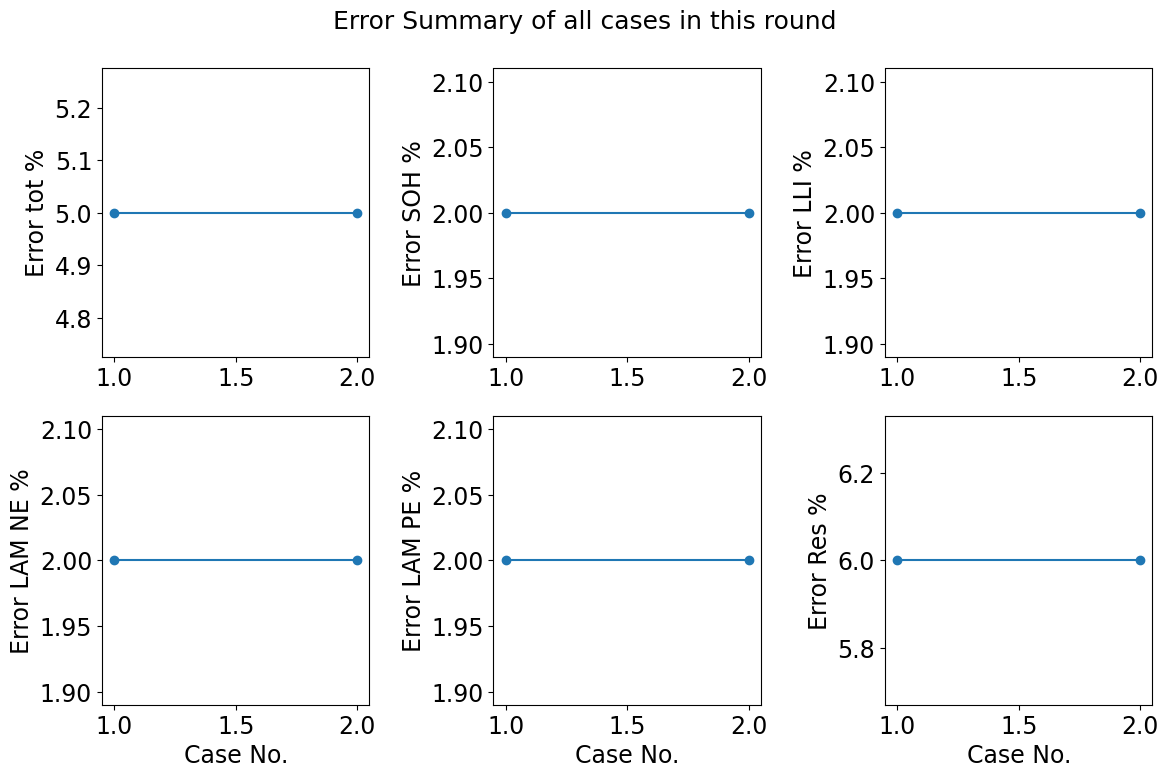

In [11]:
# After finish scans, get summary of the errors of all cases:
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Caes_Index = np.arange(1,len(midc_merge_all)+1)
Mpe_tot = []; Mpe_1 = [];Mpe_2 = []; Mpe_3 = [];Mpe_4 = []; Mpe_5 = [];
for i in range(len(midc_merge_all)):
    Mpe_tot.append(midc_merge_all[i]["Error tot %"])
    Mpe_1.append(midc_merge_all[i]["Error SOH %"])
    Mpe_2.append(midc_merge_all[i]["Error LLI %"])
    Mpe_3.append(midc_merge_all[i]["Error LAM NE %"])
    Mpe_4.append(midc_merge_all[i]["Error LAM PE %"])
    Mpe_5.append(midc_merge_all[i]["Error Res %"])
Mpe_All = [Mpe_tot,Mpe_1,Mpe_2,Mpe_3,Mpe_4,Mpe_5]
Str_All = [
    "Error tot %","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %"]
fig, axs = plt.subplots(2,3, figsize=(12,8),tight_layout=True)
for i in range(6):
    if i<=2: # 0,1,2
        m=0; n = i
    else:   # 3,4,5 
        m=1; n = i-3
    axs[m,n].plot( Caes_Index,  Mpe_All[i], '-o',  )
    axs[m,n].set_ylabel(Str_All[i])
    axs[1,n].set_xlabel("Case No.")
    fig.suptitle(
        f"Error Summary of all cases in this round", 
        fontsize=fs+1)
plt.savefig(
    BasicPath + Target+
    f"0!_Error Summary of all cases in this round.png", dpi=600)
plt.savefig(
    BasicPath + Target+
    f"0!_Error Summary of all cases in this round.svg")

In [12]:
Index_List_succeed = index_list
for index_i in Index_List_succeed:
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = index_i # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 


Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
